In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import defaultdict
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [3]:
df = pd.read_csv('complessivo_rms_finale.csv', index_col='id')
#df = df.drop(columns=['error', 'duration'])
df0 = pd.read_csv('flat_df_no_nulli.csv', index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
2,0.005965,0.030530,0.038409,0.052510,0.081335,0.096664,0.092021,0.083451,0.083296,0.086539,...,0.167174,0.126127,0.111858,0.095006,0.099327,0.097803,0.107587,0.152822,0.177150,0.000000
3,0.009710,0.088201,0.120011,0.128533,0.150989,0.169258,0.205793,0.261233,0.279276,0.259404,...,0.126499,0.103162,0.147984,0.207548,0.256682,0.254089,0.194205,0.146202,0.119663,0.121850
5,0.004292,0.036312,0.051975,0.046670,0.203390,0.283229,0.314644,0.322023,0.293859,0.251127,...,0.318426,0.312173,0.305558,0.281919,0.234308,0.178978,0.163058,0.143980,0.120217,0.107188
10,0.110271,0.142744,0.156790,0.131847,0.125279,0.129176,0.128395,0.171358,0.298087,0.304533,...,0.296138,0.217364,0.184314,0.176318,0.161866,0.158079,0.158619,0.148111,0.146005,0.000000
20,0.245351,0.239747,0.211342,0.181047,0.184478,0.177384,0.142504,0.206317,0.242042,0.226818,...,0.333991,0.285059,0.176683,0.181024,0.188473,0.168699,0.164692,0.181571,0.183699,0.000000


# Preprocessing

In [4]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

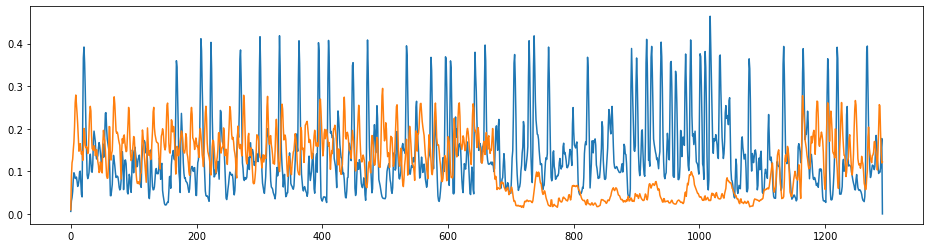

In [5]:
plt.figure(figsize=(16, 4))

ts1 = df[df.index==2].T.values
ts2 = df[df.index==3].T.values

plt.plot(ts1)
plt.plot(ts2)
plt.show()

## Amplitude Scaling

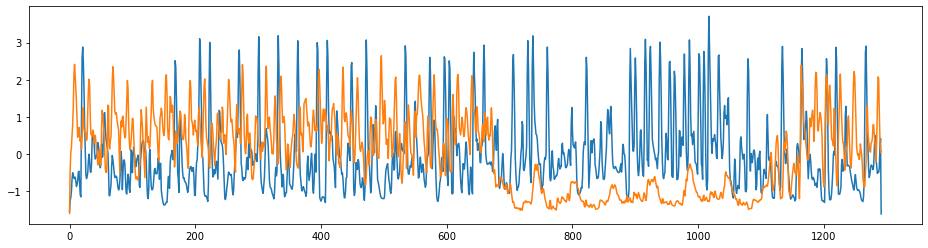

In [6]:
plt.figure(figsize=(16, 4))

scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)  # Rescale time series
ts1_scaled = scaler.fit_transform(ts1.reshape(1, -1)).flatten()
ts2_scaled = scaler.fit_transform(ts2.reshape(1, -1)).flatten()

plt.plot(ts1_scaled)
plt.plot(ts2_scaled)
plt.show()

## Noise (smoothing)

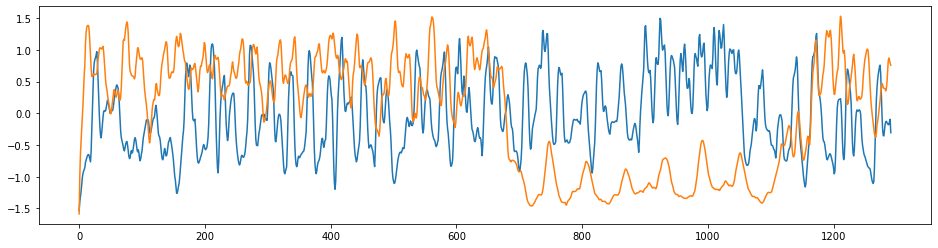

In [12]:
plt.figure(figsize=(16, 4))
w = 10

ts1_ = pd.Series(ts1.reshape(1, -1).squeeze())
ts2_ = pd.Series(ts2.reshape(1, -1).squeeze())

plt.plot(((ts1_ - ts1_.mean())/ts1_.std()).rolling(window=w, min_periods=1).mean())
plt.plot(((ts2_ - ts2_.mean())/ts2_.std()).rolling(window=w, min_periods=1).mean())
plt.show()

In [13]:
#Amplitude scaling
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)
df = df.T.apply(lambda x: scaler.fit_transform(x.values.reshape(1, -1)).flatten()).T
df

In [14]:
indici_rock  = df0[df0["TRACK_genre_top"] == "Rock"].index
indici_experimental  = df0[df0["TRACK_genre_top"] == "Experimental"].index

In [15]:
df_rock = df[df.index.isin(indici_rock)]
df_experimental = df[df.index.isin(indici_experimental)]
df_unito = df_rock.append(df_experimental)

In [17]:
print("df_rock: ", df_rock.shape)
print("df_experimental: ", df_experimental.shape)

df_unito

df_rock:  (14145, 1292)
df_experimental:  (10540, 1292)


,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
135,-6.046377,-2.881086,-0.996917,-0.883645,-1.084242,-1.348658,-1.805351,-1.777673,-1.529975,-1.666838,...,-0.707749,-1.167440,-1.530858,-0.766766,-0.599162,-0.853152,-0.723937,-0.647152,-0.563632,-7.118303
136,-5.149172,-2.359611,-1.137363,-1.296591,-0.877115,-0.305379,0.061769,-0.239576,0.202038,0.586434,...,1.122819,0.481603,-0.178366,-0.594349,-0.383701,-0.320977,-0.571100,-0.221408,0.212160,-5.672203
151,-0.547300,0.363695,1.039317,0.901499,0.573854,0.512503,1.093772,1.117792,1.199774,1.258969,...,-1.539044,-1.502183,-1.639542,-1.864820,-1.930886,-1.903494,-1.816058,-1.747970,-1.824263,-1.840853
152,-2.601652,-1.704117,-1.115991,-0.918132,-0.303977,0.069120,0.662612,1.269663,1.317505,1.105831,...,-0.422592,-1.048058,-1.394268,-1.072803,-0.368870,-0.068639,0.646865,2.136833,1.704858,-0.067111
153,-2.462335,-1.550510,-1.116279,-0.874902,-0.443990,0.236292,1.159422,1.126820,0.633012,0.397567,...,2.923811,1.830183,0.659204,0.251157,0.303776,1.293978,1.004556,-0.149984,0.805767,0.673855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148465,-0.230786,0.020392,0.035044,-0.156681,-0.057613,-0.117360,-0.299934,-0.367480,-0.079318,0.098343,...,0.953566,1.095236,1.473120,1.631638,1.644596,1.955993,1.930995,2.061227,2.321834,2.019845
148466,-0.894991,-0.677263,-0.417830,-0.351799,-0.526660,-0.713885,-0.658111,0.143644,1.699303,2.067916,...,0.986209,0.427035,-0.077088,-0.115519,0.291163,0.804829,0.887329,0.373704,-0.303367,-0.288317
148467,-0.823195,-0.522747,-0.311772,-0.350285,-0.347820,-0.390273,-0.401527,-0.290374,-0.157405,-0.252397,...,0.087335,0.049203,-0.040250,-0.106063,0.090625,0.457421,0.542448,0.478188,0.460171,0.367229


# Clustering

## Shape-based Clustering

In [18]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks

C:\Users\cri98\anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [20]:
#X = df_unito.values
X = df_rock.values

In [33]:
km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=50, random_state=0, n_jobs=-1)
km.fit(X)

TimeSeriesKMeans(n_clusters=5, n_jobs=-1, random_state=0)

In [34]:
km.cluster_centers_.shape

(5, 1292, 1)

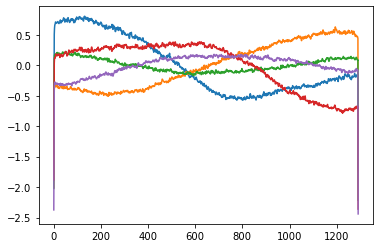

In [35]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [36]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, km.labels_)

silhouette_avg

0.009930341897014446

In [154]:
unique, counts = np.unique(km.labels_, return_counts=True)
unique, counts

(array([0, 1, 2], dtype=int64), array([188, 521, 291], dtype=int64))

In [31]:
km.inertia_

1193.3508896763185

In [43]:
X[:1000, :426].shape

(1000, 426)

In [49]:
km_dtw = TimeSeriesKMeans(n_clusters=3, metric="softdtw", max_iter=5, random_state=0, n_jobs=-1)
km_dtw.fit(X[:1000, :426])

TimeSeriesKMeans(max_iter=5, metric='softdtw', n_jobs=-1, random_state=0)

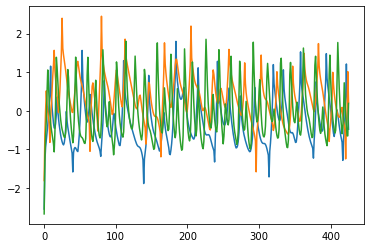

In [50]:
plt.plot(np.squeeze(km_dtw.cluster_centers_).T)
plt.show()

In [51]:
km_dtw.labels_

array([0, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 2, 0, 0, 2, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1,
       0, 1, 1, 2, 0, 0, 1, 2, 0, 1, 0, 1, 2, 1, 0, 1, 1, 2, 0, 2, 0, 0,
       0, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2,
       2, 2, 0, 1, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 1, 2, 0,
       0, 2, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       2, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 2, 2, 1, 0, 2,
       2, 1, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 2, 1, 2, 1,
       2, 0, 2, 2, 1, 2, 1, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 2, 1, 2, 0, 2, 1, 0, 0, 1, 2, 0,

In [52]:
km_dtw.inertia_

144729.68361683786

In [53]:
import pickle
pickle.dump(km_dtw, open("TimeSeriesKMeans.pickle", 'wb'))

#TimeSeriesKMeans = pickle.load(open("TimeSeriesKMeans.pickle", 'rb'))

In [159]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

## Features-based Clustering

In [156]:
from sklearn.cluster import KMeans

In [160]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [163]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(F)

KMeans(n_clusters=3)

In [164]:
kmeans.inertia_

181.79962872324805

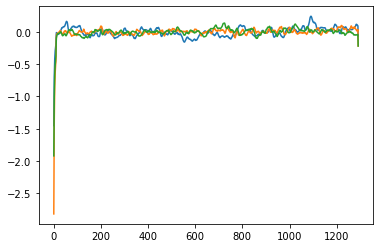

In [165]:
for i in range(3):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()